In [33]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io

# from kinect_smoothing_test import HoleFilling_Filter, Denoising_Filter

In [ ]:
rgb_img = cv2.imread('data/rgb/rgb_01.png')[:,:,::-1]
# rgb_img = get_block_center(rgb_img)
# plt.imshow(img_block)
depth_img = cv2.imread('data/depth/depth_01.png',cv2.IMREAD_UNCHANGED)
# Shift the depth image to the right by 8 pixels
rows,cols = depth_img.shape
M = np.float32([[1,0,4],[0,1,4]])
dst = cv2.warpAffine(depth_img,M,(cols,rows))
depth_img = dst

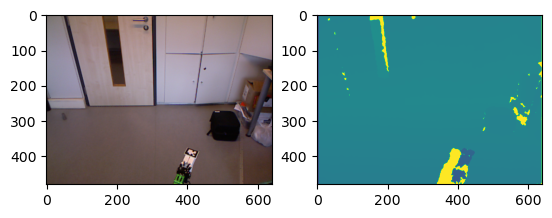

In [3]:
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(rgb_img[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(dst)

In [4]:
def get_block_center(img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # 调用回调函数，获取滑动条的值
        lower_hsv = np.array([0, 220, 102])
        upper_hsv = np.array([179, 255, 255])
        # 获得指定颜色范围内的掩码
        mask_hsv = cv2.inRange(imgHSV, lower_hsv, upper_hsv)
        contours, hierarchy = cv2.findContours(mask_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Find the largest contour (largest connected component)
        max_contour = max(contours, key=cv2.contourArea)
        # Create an empty image to draw the ellipse
        ellipse_img = np.zeros_like(mask_hsv)
        # Fit an ellipse to the largest contour
        ellipse = cv2.fitEllipse(max_contour)
        center = (int(ellipse[0][0]), int(ellipse[0][1]))
        cv2.circle(ellipse_img, center, 4, 255, thickness=cv2.FILLED)
        # # Apply the mask to the original image
        imgResult_hsv = cv2.bitwise_and(img, img, mask=ellipse_img).astype(np.uint8)
        return imgResult_hsv

In [5]:
# rgb_img = get_block_center(rgb_img)
# plt.imshow(img_block)


In [6]:
class camera():
    def __init__(self):
        self.ir_intrinsic_matrix = np.array(
            [[580.938217500424, 0,317.617632886121],
            [0, 579.637279926675, 246.729727555759], [0, 0, 1]])
        self.ir_distortion_matrix = np.array(
          [-0.203726937212412,0.888177301091217,0.002407122300079,-0.005097629434545, 0])
        self.rgb_intrinsic_matrix = np.array(
            [[516.807042827898, 0, 334.465952581250],
            [0, 515.754575693376, 256.996105088827], [0, 0, 1]])
        self.rgb_distortion_matrix = np.array(
           [0.205630360349696,-0.666613712966367,0.007397174890620,-0.003644398316505, 0])

        self.A = np.array([[
            0.999960280047999, -0.00552879643268073,-0.00699076078363541,
           -25.2137311361220
        ],
                            [
                              0.00555933604534934,0.999975056126553,
                              0.00435670832530621, 0.158410973817053
                            ],
                            [
                               0.00696649905353596,-0.00439539926546948,
                               0.999966073602617,-0.282858204409621
                            ]])
        self.imgsz = [640, 480]
        self.dist_img = None
        return

    def rectify(self):

        return

    def undistortion(self, distorted_img, camera_type):
        # Correcting the distortion
        if camera_type == 'rgb':
            camera_matrix, roi = cv2.getOptimalNewCameraMatrix(
                self.rgb_intrinsic_matrix, self.rgb_distortion_matrix,
                self.imgsz, 1, self.imgsz)
            undistorted_img = cv2.undistort(
                distorted_img, self.rgb_intrinsic_matrix,
                self.rgb_distortion_matrix, None,
                camera_matrix)  # Correcting the distortion
        elif camera_type == 'ir':
            camera_matrix, roi = cv2.getOptimalNewCameraMatrix(
                self.ir_intrinsic_matrix, self.ir_distortion_matrix,
                self.imgsz, 1, self.imgsz)
            undistorted_img = cv2.undistort(
                distorted_img.astype(np.float64), self.ir_intrinsic_matrix,
                self.ir_distortion_matrix, None,
                camera_matrix)  # Correcting the distortion
        return undistorted_img, camera_matrix

In [7]:
kinect = camera()
# w = 640
# h = 480

rgb_img, mtx_rgb = kinect.undistortion(rgb_img,'rgb')
_, mtx_ir = kinect.undistortion(depth_img,'ir')
# mtx_rgb = kinect.rgb_intrinsic_matrix
# mtx_ir = kinect.ir_intrinsic_matrix

# objpoints = []
# R = kinect.A[:3,:3]
# t = kinect.A[:,3]
# result= \
#     cv2.stereoRectify(mtx_rgb,kinect.rgb_distortion_matrix, mtx_ir, kinect.ir_distortion_matrix, kinect.imgsz,R,t)   #再做双目标定



In [8]:
mtx_ir

array([[590.45119738,   0.        , 315.70761834],
       [  0.        , 574.62069487, 247.17363674],
       [  0.        ,   0.        ,   1.        ]])

In [9]:
dist = 0.1236 * np.tan((depth_img) / 2842.5 + 1.1863)*1000-37
# dist =  0.1236 * np.tan((depth_img) / 2842.5 + 1.1863)*1000

epsilon = 1e-5  # A small constant to avoid division by zero
# dist = 0.075 * 580 / (1090 - depth_img) * 8*1000

# dist = 1/(depth_img*(-0.0030711016)+3.3309495161)*1000

dist[dist<400] = 0
dist[dist>1000] = 0
depth_img.shape

(480, 640)

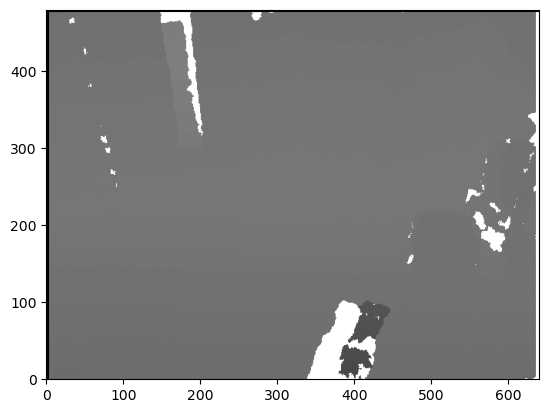

In [10]:
plt.imshow(depth_img, cmap='gray', extent=(0, depth_img.shape[1], 0, depth_img.shape[0]))
plt.gca().set_aspect('equal', adjustable='box')  # 保持纵横比相等

In [11]:
def pixel2world(x, y, intrinsic_matrix, dist):
    cx = intrinsic_matrix[0, 2]
    cy = intrinsic_matrix[1, 2]
    fx = intrinsic_matrix[0, 0]
    fy = intrinsic_matrix[1, 1]
    Z = dist[y, x]
    X = (x - cx) * (Z) / fx
    Y = (y - cy) * (Z) / fy

    return X, Y, Z

In [12]:
x = np.tile(np.arange(640), (480, 1))
y = np.tile(np.arange(480).reshape(-1, 1), (1, 640))
X, Y, Z = pixel2world(x, y, mtx_ir, dist)
# Flatten the matrices
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()

# Combine into a single array of 3D points
points_3d = np.vstack((X_flat, Y_flat, Z_flat)).T
# Remove rows where Z < 0
points_3d = points_3d[points_3d[:, 2] >= 0]

In [13]:
import open3d as o3d
import numpy as np
FOR1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
# Let's say 'points_3d' is your array of 3D points (numpy array)
# points_3d.shape should be (N, 3), where N is the number of points

# Create an Open3D point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd,FOR1])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [14]:
points_3d = np.append(points_3d.T, np.ones((1,points_3d.shape[0])),axis=0).T

In [15]:
E = kinect.A
K = mtx_rgb
T_ir2rgb = K.dot(E)
raw_pixel = T_ir2rgb.dot(points_3d.T).T

In [16]:
mtx_rgb

array([[358.17276988,   0.        , 280.78313962],
       [  0.        , 362.00182368, 220.39012275],
       [  0.        ,   0.        ,   1.        ]])

In [17]:
rgb_pixel = np.round((raw_pixel/(raw_pixel[:,-1]).reshape(-1,1))).astype(int)

<Axes: ylabel='Frequency'>

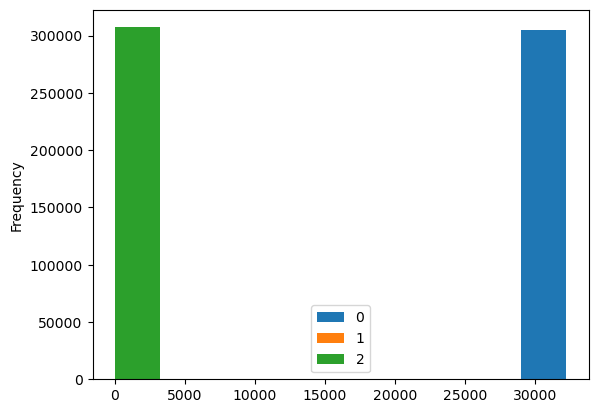

In [18]:
df_rgb_pixel = pd.DataFrame(rgb_pixel)
df_rgb_pixel.plot.hist()

In [19]:
h = points_3d.shape[0]
points_3d_color  = np.zeros((h,3))
block_pcd_index = []
for i,v in enumerate(points_3d):
    u,v = rgb_pixel[i][:2]
    if u>=640 or v>=480:
        pc =  np.array([np.nan,np.nan,np.nan])
    elif  u<0 or v<0:
        pc = np.array([np.nan,np.nan,np.nan])
    else:
        pc = rgb_img[v,u]
        if not np.array_equal(pc,np.array([0,0,0])):    
            block_pcd_index.append(i)
    points_3d_color[i] = pc


In [20]:
block_3d = points_3d[block_pcd_index]

In [32]:
# Creating a point cloud object
block_pcd = o3d.geometry.PointCloud()

# points_3d[:,0] = points_3d[:,0]
# Assigning the points
block_pcd.points = o3d.utility.Vector3dVector(block_3d[:, :3])

# Assigning the colors
pcd.colors = o3d.utility.Vector3dVector(points_3d_color[:,[2, 1,0]]/ 255.0)
FOR1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=200, origin=[0, 0, 0])

# Visualizing the point cloud
o3d.visualization.draw_geometries([block_pcd,FOR1])
# 使用 numpy 计算点云的质心
points_array = np.asarray(block_pcd.points)
centroid = np.mean(points_array, axis=0)

# 打印质心坐标
print("质心坐标:", centroid)




质心坐标: [117.61344618 221.61202716 721.02311839]


In [22]:
# Creating a point cloud object
pcd = o3d.geometry.PointCloud()

# points_3d[:,0] = points_3d[:,0]
# Assigning the points
pcd.points = o3d.utility.Vector3dVector(points_3d[:, :3])

# Assigning the colors
pcd.colors = o3d.utility.Vector3dVector(points_3d_color[:,[2, 1,0]]/ 255.0)
FOR1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=200, origin=[0, 0, 0])

# Visualizing the point cloud
o3d.visualization.draw_geometries([pcd,FOR1])

In [23]:
downpcd = pcd.uniform_down_sample(every_k_points = 10)
# Visualizing the point cloud
o3d.visualization.draw_geometries([downpcd,FOR1])

In [24]:
plane_model, inliers = downpcd.segment_plane(distance_threshold=10,
                                         ransac_n=5000,
                                         num_iterations=10)

[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = downpcd.select_by_index(inliers)
# plane_model, inliers = inlier_cloud.segment_plane(distance_threshold=50,
#                                          ransac_n=100,
#                                          num_iterations=100)
# inlier_cloud = inlier_cloud.select_by_index(inliers)

inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = downpcd.select_by_index(inliers, invert=True)
outlier_cloud.paint_uniform_color([0, 1, 0])
o3d.visualization.draw_geometries([outlier_cloud])

Plane equation: 0.91x + 0.32y + -0.25z + 0.00 = 0


In [25]:
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        outlier_cloud.cluster_dbscan(eps=50, min_points=60, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
outlier_cloud.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([outlier_cloud])


[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 1
point cloud has 1 clusters


In [26]:
np.asarray(outlier_cloud.points)
np.asarray(outlier_cloud.colors)


array([[0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.

In [27]:
# Remove radius outliers
cleaned_cloud = outlier_cloud.remove_radius_outlier(nb_points=10, radius=60)
cleaned_cloud = cleaned_cloud[0].random_down_sample(0.90)
# o3d.visualization.draw_geometries([cleaned_cloud])


In [28]:
import open3d as o3d

# Create a mesh from the point cloud using alpha shape
# mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(cleaned_cloud, alpha=0.01)
tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(cleaned_cloud)

mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
    cleaned_cloud, 0.015*1000, tetra_mesh, pt_map)
mesh.compute_vertex_normals()

# o3d.visualization.draw_geometries([mesh])
# Save the mesh as a PLY file
o3d.io.write_triangle_mesh("data/other/point_cloud.ply", mesh)
import open3d as o3d

# 假设您的点云已经存储在变量 cloud 中，类型为 Open3D 的 PointCloud 对象

# 将点云转换为三角网格

# 计算三角网格的表面积
surface_area = mesh.compute_triangle_normals().get_surface_area()

print("点云的表面积为:", surface_area)

点云的表面积为: 2298.135149299009


In [29]:
import open3d as o3d

# Assuming cleaned_cloud is your point cloud
# Compute normal vectors for the point cloud
cleaned_cloud.estimate_normals()

In [30]:
tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(cleaned_cloud)

mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
    cleaned_cloud, 0.015*1000, tetra_mesh, pt_map)
mesh.compute_vertex_normals()

# o3d.visualization.draw_geometries([mesh])

TriangleMesh with 53 points and 100 triangles.

In [31]:
plane_model, inliers = cleaned_cloud.segment_plane(distance_threshold=200,
                                         ransac_n=10,
                                         num_iterations=500)
inlier_cloud = cleaned_cloud.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = cleaned_cloud.select_by_index(inliers, invert=True)
outlier_cloud.paint_uniform_color([0, 1, 0])
# o3d.visualization.draw_geometries([inlier_cloud,outlier_cloud])

PointCloud with 0 points.